### Index
- Overview
- 기본적인 추천시스템
    - Recommendation Based on Popularity
    - Recommendation Based on Correlation

- Implementation with 'surprise'
- CF(Collaborative Filtering)
    - Classification-based Collaborative Filtering Systems
    - Model-based Collaborative Filtering Systems
- CBF(Content-Based Filtering)
- Evaluating Recommendation Systems

## Overview

### 배경

- 정보홍수의 시대(Information Overload): 정보의 과잉으로 이용자가 모든 정보의 가치 유무를 판단할 수 없는 상태 

- __Information Filtering__ 에 대한 수요가 급증한다

- Filtering은 __'검색'__ 과 __'추천'__ 으로 나뉜다

    - __검색__: 이용자가 원하는 정보를 검색어(Query)를 통해 찾아주는 방식

    - __추천__: 검색어와 같은 명시적인 요청이 없어도 이용자의 서비스 사용 패턴(과거 데이터)을 기반으로 컨텐츠를 제공하는 보다 능동적인 방식

> 다양한 고객취향을 고려하여 상품에 대한 새로운 수요를 이끌어 낼 수 있기에 상업적 가치가 높다
> ![1](https://user-images.githubusercontent.com/38183218/47250014-67e2e880-d456-11e8-85e4-1f54a48fcec4.PNG)

> 협업필터링(CF)과 컨텐츠기반 필터링(CBF)가 기본

> 각각 CF와 CBF

> ![2](https://user-images.githubusercontent.com/38183218/47250101-4b937b80-d457-11e8-92c3-7283e54ea6d9.PNG)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import surprise
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import NormalPredictor, BaselineOnly, KNNBasic, SVD

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report


### Popularity based Recommender system


#### 예제: MovieLens 데이터
    - MovieLens 100K Dataset
    - Stable benchmark dataset. 100,000 ratings from 1000 users on 1700 movies. Released 4/1998.
    - user_id, movie_id, rating의 세 요소와 timestamp 컬럼으로 구성


http://grouplens.org/datasets/movielens/100k/

In [2]:
r_cols=['user_id','movie_id','rating','timestamp']
rating = pd.read_table('data/ml-100k/u.data',names=r_cols)
rating['date'] = pd.to_datetime(rating['timestamp'], unit='s')
rating.drop(columns='timestamp',inplace=True)
rating.head()

,user_id,movie_id,rating,date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [3]:
# user_id 를 pk로 하는 user table
u_cols = ['user_id','age','sex','job','zip_code']

user = pd.read_table('data/ml-100k/u.user',sep='|',names=u_cols,index_col='user_id')
user.head()

,age,sex,job,zip_code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [4]:
# movie_id를 pk로 하는 movie table
m_cols = ['movie_id','title','release_date','video_release','imdb_url']
movie = pd.read_table('data/ml-100k/u.item',encoding='ISO-8859-1',sep='|',names=m_cols,usecols=range(5),index_col='movie_id')
movie.head()

,title,release_date,video_release,imdb_url
movie_id,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [5]:
movie_rating = pd.merge(movie,rating,on='movie_id',how='inner')
movie_rating.head()

,movie_id,title,release_date,video_release,imdb_url,user_id,rating,date
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,1998-02-17 17:28:52
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,287,5,1997-09-27 04:21:28
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,148,4,1997-10-16 16:30:11
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,280,4,1998-04-04 14:33:46
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,66,3,1997-12-31 20:48:44


In [6]:
lens = pd.merge(movie_rating,user,on='user_id')

use, movie, rating 테이블을 조인해 lens 테이블 구성

In [7]:
lens.head()

,movie_id,title,release_date,video_release,imdb_url,user_id,rating,date,age,sex,job,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,1998-02-17 17:31:36,60,M,retired,95076


In [8]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
movie_id         100000 non-null int64
title            100000 non-null object
release_date     99991 non-null object
video_release    0 non-null float64
imdb_url         99987 non-null object
user_id          100000 non-null int64
rating           100000 non-null int64
date             100000 non-null datetime64[ns]
age              100000 non-null int64
sex              100000 non-null object
job              100000 non-null object
zip_code         100000 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 9.9+ MB


In [9]:
lens.describe()

,movie_id,video_release,user_id,rating,age
count,100000.000000,0.0,100000.00000,100000.000000,100000.000000
mean,425.530130,NaN,462.48475,3.529860,32.969850
std,330.798356,NaN,266.61442,1.125674,11.562623
min,1.000000,NaN,1.00000,1.000000,7.000000
25%,175.000000,NaN,254.00000,3.000000,24.000000
50%,322.000000,NaN,447.00000,4.000000,30.000000
75%,631.000000,NaN,682.00000,4.000000,40.000000
max,1682.000000,NaN,943.00000,5.000000,73.000000


일반적인 랭크에 기반한 추천

In [10]:
lens.title.value_counts().iloc[:10] # rating한 유저 수가 가장 많은 영화 top10

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [11]:
lens.groupby('title').mean()[['rating']].sort_values('rating',ascending=False).iloc[:15,:] # 평점평균의  top 15

,rating
title,
They Made Me a Criminal (1939),5.000
Marlene Dietrich: Shadow and Light (1996),5.000
"Saint of Fort Washington, The (1993)",5.000
Someone Else's America (1995),5.000
Star Kid (1997),5.000
"Great Day in Harlem, A (1994)",5.000
Aiqing wansui (1994),5.000
Santa with Muscles (1996),5.000
Prefontaine (1997),5.000


In [12]:
lens.groupby('user_id').size().sort_values(ascending=False).iloc[:10] # 유저별 rating 수 top10

user_id
405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
dtype: int64

In [13]:
movie_stats = lens.groupby('title').agg({'rating':[np.size,np.mean]}) #agg를 이용해 size와 mean 한번에 
movie_stats.head(10)

rating          
                                              size      mean
title                                                       
'Til There Was You (1997)                        9  2.333333
1-900 (1994)                                     5  2.600000
101 Dalmatians (1996)                          109  2.908257
12 Angry Men (1957)                            125  4.344000
187 (1997)                                      41  3.024390
2 Days in the Valley (1996)                     93  3.225806
20,000 Leagues Under the Sea (1954)             72  3.500000
2001: A Space Odyssey (1968)                   259  3.969112
3 Ninjas: High Noon At Mega Mountain (1998)      5  1.000000
39 Steps, The (1935)                            59  4.050847

In [14]:
atleast_100 = movie_stats['rating']['size'] >=100 # size 100 이상이라는 masking줘서 선별
movie_stats[atleast_100].sort_values(by=[('rating','mean')], ascending= False)

rating          
                                                     size      mean
title                                                              
Close Shave, A (1995)                                 112  4.491071
Schindler's List (1993)                               298  4.466443
Wrong Trousers, The (1993)                            118  4.466102
Casablanca (1942)                                     243  4.456790
Shawshank Redemption, The (1994)                      283  4.445230
Rear Window (1954)                                    209  4.387560
Usual Suspects, The (1995)                            267  4.385768
Star Wars (1977)                                      583  4.358491
12 Angry Men (1957)                                   125  4.344000
Citizen Kane (1941)                                   198  4.292929
To Kill a Mockingbird (1962)                          219  4.292237
One Flew Over the Cuckoo's Nest (1975)                264  4.291667
Silence of the Lambs, The (1991)                      390  4.289744
North by Northwest (1959)                             179  4.284916
Godfather, The (1972)                                 413  4.283293
Secrets & Lies (1996)                                 162  4.265432
Good Will Hunting (1997)                              198  4.262626
Manchurian Candidate, The (1962)                      131  4.259542
Dr. Strangelove or: How I Learned to Stop Worry...    194  4.252577
Raiders of the Lost Ark (1981)                        420  4.252381
Vertigo (1958)                                        179  4.251397
Titanic (1997)                                        350  4.245714
Lawrence of Arabia (1962)                             173  4.231214
Maltese Falcon, The (1941)                            138  4.210145
Empire Strikes Back, The (1980)                       367  4.204360
Boot, Das (1981)                                      201  4.203980
Sling Blade (1996)                                    136  4.198529
As Good As It Gets (1997)                             112  4.196429
Godfather: Part II, The (1974)                        209  4.186603
African Queen, The (1951)                             152  4.184211
...                                                   ...       ...
Ace Ventura: Pet Detective (1994)                     103  3.048544
Conan the Barbarian (1981)                            107  3.046729
Grumpier Old Men (1995)                               148  3.040541
Star Trek: The Motion Picture (1979)                  117  3.034188
Broken Arrow (1996)                                   254  3.031496
First Wives Club, The (1996)                          160  3.018750
Net, The (1995)                                       120  3.008333
Evita (1996)                                          259  2.980695
Natural Born Killers (1994)                           128  2.953125
Lost World: Jurassic Park, The (1997)                 158  2.943038
Dante's Peak (1997)                                   240  2.933333
Nutty Professor, The (1996)                           163  2.914110
101 Dalmatians (1996)                                 109  2.908257
Father of the Bride Part II (1995)                    128  2.898438
Mars Attacks! (1996)                                  217  2.847926
Multiplicity (1996)                                   134  2.835821
Alien 3 (1992)                                        100  2.830000
Volcano (1997)                                        219  2.808219
Waterworld (1995)                                     102  2.803922
Beavis and Butt-head Do America (1996)                156  2.788462
Mimic (1997)                                          101  2.742574
Down Periscope (1996)                                 101  2.702970
George of the Jungle (1997)                           162  2.685185
Batman Returns (1992)                                 142  2.683099
Batman Forever (1995)                                 114  2.666667
Spawn (1997)                           

예제: cuisine-place data

In [15]:
frame = pd.read_csv('data/rating_final.csv')
cuisine = pd.read_csv('data/chefmozcuisine.csv')

In [16]:
frame.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [17]:
cuisine.head()

,placeID,Rcuisine
0,135110,Spanish
1,135109,Italian
2,135107,Latin_American
3,135106,Mexican
4,135105,Fast_Food


In [18]:
cuisine_rating = pd.merge(frame,cuisine, on='placeID')

In [19]:
cuisine_rating.head()

,userID,placeID,rating,food_rating,service_rating,Rcuisine
0,U1077,135085,2,2,2,Fast_Food
1,U1108,135085,1,2,1,Fast_Food
2,U1081,135085,1,2,1,Fast_Food
3,U1056,135085,2,2,2,Fast_Food
4,U1134,135085,2,1,2,Fast_Food


In [20]:
cuisine_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Data columns (total 6 columns):
userID            1043 non-null object
placeID           1043 non-null int64
rating            1043 non-null int64
food_rating       1043 non-null int64
service_rating    1043 non-null int64
Rcuisine          1043 non-null object
dtypes: int64(4), object(2)
memory usage: 57.0+ KB


In [21]:
cuisine_rating.groupby(['Rcuisine','placeID']).agg({'rating':[np.size,np.mean]}) # 종류별, 음식점별 rating, size와 mean

rating          
                           size      mean
Rcuisine         placeID                 
American         132583       4  1.000000
                 132851       7  1.428571
                 132872      12  0.916667
                 132951      10  1.000000
                 132958       6  1.666667
Armenian         132667       4  1.250000
Bakery           132866       5  1.400000
Bar              132921      17  1.235294
                 132937       4  1.500000
                 134983       5  1.000000
                 135019       6  1.333333
                 135026      11  1.363636
                 135041      17  1.176471
                 135048       6  1.000000
                 135052      25  1.280000
                 135057      15  1.266667
                 135059       9  1.666667
                 135069      12  0.500000
                 135071       9  1.000000
                 135073       4  1.500000
Bar_Pub_Brewery  132955       5  2.000000
                 134983       5  1.000000
                 135026      11  1.363636
                 135052      25  1.280000
                 135071       9  1.000000
                 135073       4  1.500000
Breakfast-Brunch 132954       9  1.000000
Burgers          132858       5  0.800000
                 132861       7  1.428571
                 132870       5  0.600000
...                         ...       ...
Mexican          132723      12  1.416667
                 132732       8  0.625000
                 132740       8  0.750000
                 132754      13  1.461538
                 132755       5  1.800000
                 132773       4  1.500000
                 132825      32  1.281250
                 132834      25  1.000000
                 132845       5  0.800000
                 132925       5  1.000000
                 134976       4  1.750000
                 135018       4  1.500000
                 135025      15  1.666667
                 135027       8  0.875000
                 135028      15  1.533333
                 135055       7  1.714286
                 135104       7  0.857143
                 135106      10  1.200000
Pizzeria         132733      10  1.300000
                 132869       6  1.166667
                 135043       9  0.888889
                 135053       8  1.125000
                 135058      18  1.111111
Regional         132560       4  0.500000
Seafood          135039      12  1.250000
                 135049       5  1.000000
                 135054      10  1.000000
                 135060      22  1.136364
                 135075      13  1.692308
Vietnamese       132767       6  1.166667

[112 rows x 2 columns]

geodata 추가

In [22]:
# frame = pd.read_csv('data/rating_final.csv')
# cuisine = pd.read_csv('data/chefmozcuisine.csv')
geodata = pd.read_csv('data/geoplaces2.csv', encoding='latin1')

In [23]:
geodata.head()

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rincón de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,...,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none


geodata의 인덱스를 placeID 컬럼으로 설정하고 rating 평균이 가장 높은 place 순으로 정렬한 인덱스를 만든다(rs_index)

In [24]:
geodata.set_index('placeID',inplace=True)

In [27]:
rs_index = cuisine_rating.groupby('placeID').mean().sum(axis=1).sort_values(ascending=False).index
rs_index

Int64Index([134986, 132955, 135034, 132755, 135074, 132922, 135055, 135075,
            134999, 135018, 135025, 132768, 132958, 132667, 135035, 134976,
            132773, 135059, 132861, 135030, 132754, 132862, 135028, 132866,
            132854, 135026, 132846, 132723, 135073, 135085, 135057, 135072,
            132584, 132733, 132869, 132767, 135019, 132717, 135048, 135042,
            135052, 135106, 132825, 132613, 132937, 135044, 132875, 135060,
            132851, 132925, 135046, 135041, 135039, 132630, 135032, 135027,
            132583, 132872, 132626, 135079, 132921, 134983, 135088, 135104,
            135058, 135021, 135043, 132608, 132834, 132668, 132706, 135109,
            132572, 135054, 135053, 132856, 132858, 132951, 132954, 132740,
            132665, 135049, 135071, 132732, 132715, 132594, 132766, 132845,
            135086, 132870, 132609, 132560, 135069, 132663, 132885],
           dtype='int64', name='placeID')

rs_index 기준으로 re_indexing 한다

In [28]:
geodata = geodata.reindex(index=rs_index)

In [30]:
geodata['name'].head(10) #평점기반으로 추천했다

placeID
134986                   Restaurant Las Mananitas
132955                                  emilianos
135034                 Michiko Restaurant Japones
132755                       La Estrella de Dimas
135074          Restaurante la Parroquia Potosina
132922                       cafe punta del cielo
135055    la Cochinita Pibil Restaurante Yucateco
135075                       Mariscos El Pescador
134999                            Kiku Cuernavaca
135018                           El Oceano Dorado
Name: name, dtype: object

#### Recommendation Based on Correlation

우선 cross tab이용해서 wide하게 만들어보자

In [31]:
place_crosstab = pd.pivot_table(data=frame, values='rating', index='userID',columns='placeID')
place_crosstab.head()

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
U1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
U1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
U1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
place_crosstab = place_crosstab.fillna(0)
place_crosstab.head()

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
U1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
U1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
place_crosstab.corr(method='pearson').head() # place기반 corr

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
placeID,,,,,,,,,,,,,,,,,,,,,
132560,1.000000,-0.018078,-0.019766,-0.035183,-0.017023,0.364754,0.397706,-0.019847,-0.018078,-0.022148,...,-0.019847,-0.030178,-0.020321,-0.060398,-0.026743,-0.022264,0.233776,-0.027060,-0.030178,-0.017023
132561,-0.018078,1.000000,-0.024298,-0.043250,-0.020925,-0.027593,-0.022222,-0.024398,-0.022222,-0.027226,...,-0.024398,-0.037097,-0.024980,-0.074246,-0.032874,-0.027369,-0.027369,-0.033264,-0.037097,-0.020925
132564,-0.019766,-0.024298,1.000000,-0.047290,-0.022880,-0.030170,-0.024298,0.218746,-0.024298,-0.029769,...,-0.026676,-0.040562,-0.027313,-0.081181,-0.035945,-0.029925,-0.029925,-0.036371,-0.040562,-0.022880
132572,-0.035183,-0.043250,-0.047290,1.000000,-0.040726,-0.053702,-0.043250,-0.047484,-0.043250,-0.052988,...,0.098133,-0.072199,-0.048617,0.077067,0.230333,-0.053267,-0.053267,0.133796,-0.021104,-0.040726
132583,-0.017023,-0.020925,-0.022880,-0.040726,1.000000,-0.025983,-0.020925,-0.022974,-0.020925,-0.025637,...,-0.022974,-0.034932,-0.023522,-0.069914,-0.030956,0.270606,-0.025772,-0.031323,-0.034932,-0.019704


In [34]:
u_corr = place_crosstab.T.corr(method='pearson')
u_corr.head() # user 기반 corr

userID,U1001,U1002,U1003,U1004,U1005,U1006,U1007,U1008,U1009,U1010,...,U1129,U1130,U1131,U1132,U1133,U1134,U1135,U1136,U1137,U1138
userID,,,,,,,,,,,,,,,,,,,,,
U1001,1.000000,0.177522,0.106902,-0.060746,0.004865,0.050441,0.138926,-0.063104,0.048224,-0.050412,...,-0.021230,-0.021230,-0.041666,0.310872,-0.058031,0.010440,NaN,-0.066319,0.080374,-0.035629
U1002,0.177522,1.000000,0.206710,0.100876,0.035967,0.018423,0.011163,-0.070988,0.383969,-0.056710,...,-0.023882,-0.023882,-0.046871,0.358369,-0.065281,0.128066,NaN,0.271774,0.361659,0.332092
U1003,0.106902,0.206710,1.000000,-0.075665,-0.072724,0.267904,-0.076909,-0.078602,0.323740,-0.062792,...,-0.026443,-0.026443,-0.051898,0.045237,-0.072282,0.383298,NaN,-0.018685,0.424286,0.175402
U1004,-0.060746,0.100876,-0.075665,1.000000,0.115228,0.011179,0.075265,-0.065934,-0.029010,-0.052672,...,-0.022181,-0.022181,-0.043534,0.306043,-0.060633,-0.083627,NaN,0.230976,0.027992,-0.037226
U1005,0.004865,0.035967,-0.072724,0.115228,1.000000,-0.069073,0.189893,-0.063371,-0.066038,0.419462,...,-0.021319,-0.021319,-0.041842,0.023587,-0.058276,-0.080376,NaN,-0.066600,0.053809,-0.035780


In [35]:
u_corr['U1004'].sort_values(ascending=False).head() #특정 유저와 높은 corr인 유저들

userID
U1004    1.000000
U1016    0.320195
U1132    0.306043
U1024    0.285868
U1061    0.248338
Name: U1004, dtype: float64

corrwith: 두개의 DF 이용해 corr 구함

In [36]:
# similar_to_Tortas = place_crosstab.corrwith(Tortas_rating)
# corr_Tortas = pd.DataFrame(similar_to_Tortas, columns=['PearsonR'])

### Implement with surprise

surprise 모듈이용한 손쉬운 구현

In [37]:
data = surprise.Dataset.load_builtin('ml-100k')

In [38]:
type(data)

surprise.dataset.DatasetAutoFolds

In [39]:
data.raw_ratings[:10]

[('196', '242', 3.0, '881250949'),
 ('186', '302', 3.0, '891717742'),
 ('22', '377', 1.0, '878887116'),
 ('244', '51', 2.0, '880606923'),
 ('166', '346', 1.0, '886397596'),
 ('298', '474', 4.0, '884182806'),
 ('115', '265', 2.0, '881171488'),
 ('253', '465', 5.0, '891628467'),
 ('305', '451', 3.0, '886324817'),
 ('6', '86', 3.0, '883603013')]

In [40]:
algo = NormalPredictor() # DummyClassifier와 유사

In [43]:
type(NormalPredictor())

surprise.prediction_algorithms.random_pred.NormalPredictor

In [41]:
cross_validate(algo,data, cv=3)

{'fit_time': (0.16155290603637695, 0.18350934982299805, 0.17644834518432617),
 'test_mae': array([1.22175323, 1.2234525 , 1.22269449]),
 'test_rmse': array([1.52136805, 1.52060615, 1.52196437]),
 'test_time': (0.3988831043243408, 0.4916830062866211, 0.42685985565185547)}

In [42]:
x = pd.DataFrame.from_records(data.raw_ratings, columns =['user','item','rating','time'])

In [44]:
x.drop('time',axis=1,inplace=True)

In [45]:
x.set_index(['user','item'],inplace=True)

In [46]:
y = x.unstack().fillna(0)
y.iloc[:10,:10]

rating                                             
item      1   10  100 1000 1001 1002 1003 1004 1005 1006
user                                                    
1       5.0  3.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10      4.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
100     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
101     3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
102     3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
103     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
104     0.0  2.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
105     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
106     4.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
107     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

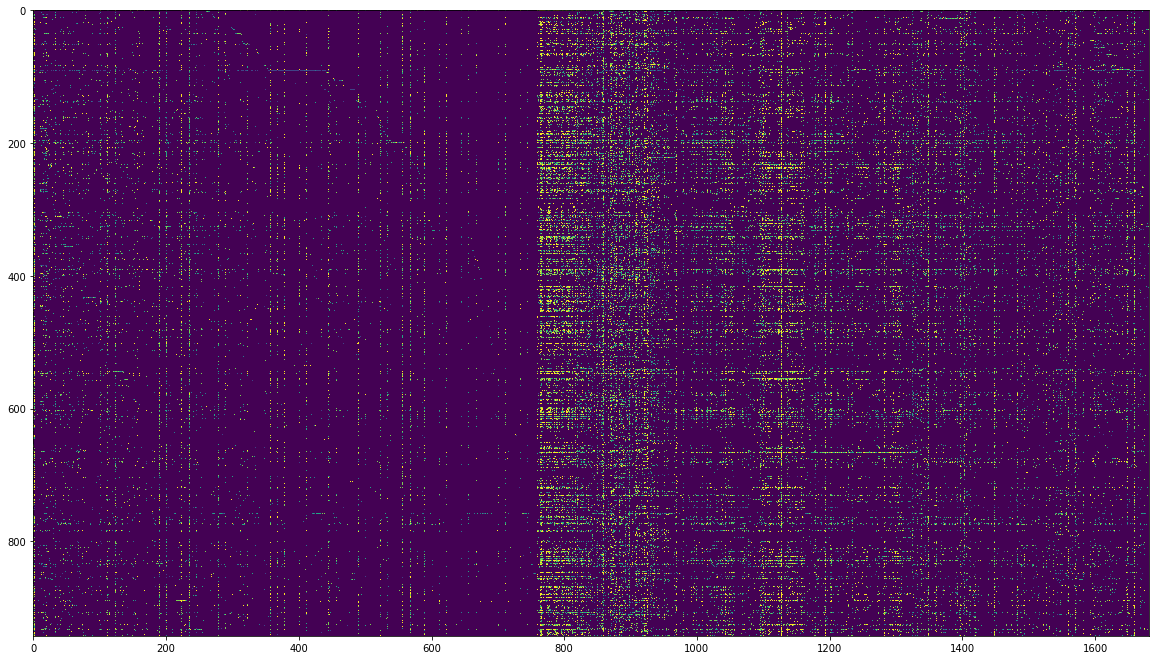

In [47]:
plt.figure(figsize=(20,20))
plt.imshow(y)

In [48]:
# 알고리즘 학습
train_data = data.build_full_trainset()

In [49]:
algo1 = BaselineOnly()
algo1.fit(train_data)

Estimating biases using als...


In [50]:
algo1.predict(1,1) # uid=1, iid=1에 대한 est_rating = 3.52986

Prediction(uid=1, iid=1, r_ui=None, est=3.52986, details={'was_impossible': False})

In [51]:
algo2 = KNNBasic()
algo2.fit(train_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [52]:
algo2.predict('1','1') # uid=1, iid=1에 대한 est_rating = 4.1299713089494405

Prediction(uid='1', iid='1', r_ui=None, est=4.1299713089494405, details={'actual_k': 40, 'was_impossible': False})

In [73]:
#SVD
param_grid = {
    'n_epochs': [5, 10], 
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

In [74]:
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9636645763220054
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


## CF
Collaborative Filtering System

- 기본적으로 해당 유저와 비슷한 성향의 유저를 찾아낸다. 그리고 그 유저가 기존에 선호하던 아이템을 추천한다
- 비슷한 패턴을 가진 사용자나 항목을 추출하는 것이 핵심이다
- 사용자들의 검색, 조회, 구매 이력 등 기존 데이터를 주로 사용
- Serendipity Recommendation 이 가능
- 다른 유저의 정보도 활용하기에 CBF에 비해 해당 유저의 'Behavior Data'가 상대적으로 많지 않아도 추천 가능
- 컨텐츠 메타 데이터 사용 않기에 텍스트 등 분석 불필요하고, 복잡한 feature extraction과 selection은 불필요
- 콜드스타트의 문제
- 롱테일의 문제: 아이템 많더라도 기존 유저들은 소수의 인기있는 아이템에 쏠린다. 관심이 적은 다수의 아이템에는 추천 위한 정보가 적은 비대칭적 구조
- 계산량 많음(sparsity)
- 독특한 취향의 유저(black sheep)의 문제

### Classification-based Collaborative Filtering Systems
#### Logistic Regression as a Classifier

This bank marketing dataset available at the UCI Machine Learning Repository 

(https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#).

In [53]:
bank_full = pd.read_csv('data/bank_full_w_dummy_vars.csv')
bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,job_unknown,job_retired,job_services,job_self_employed,job_unemployed,job_maid,job_student,married,single,divorced
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,0,0,0,0,0,0,0,1,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,1,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,0,0,0,0,0,0,0,1,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,0,0,0,0,0,0,0,1,0,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,0,0,0,0,0,0,0,1,1


In [55]:
bank_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 37 columns):
age                             45211 non-null int64
job                             45211 non-null object
marital                         45211 non-null object
education                       45211 non-null object
default                         45211 non-null object
balance                         45211 non-null int64
housing                         45211 non-null object
loan                            45211 non-null object
contact                         45211 non-null object
day                             45211 non-null int64
month                           45211 non-null object
duration                        45211 non-null int64
campaign                        45211 non-null int64
pdays                           45211 non-null int64
previous                        45211 non-null int64
poutcome                        45211 non-null object
y                               45

In [56]:
bank_full.describe()

,age,balance,day,duration,campaign,pdays,previous,y_binary,housing_loan,credit_in_default,...,job_unknown,job_retired,job_services,job_self_employed,job_unemployed,job_maid,job_student,married,single,divorced
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.00000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985,0.555838,0.018027,...,0.006370,0.050076,0.09188,0.034925,0.028820,0.027427,0.020747,0.601933,0.282896,0.282896
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406,0.496878,0.133049,...,0.079559,0.218105,0.28886,0.183592,0.167303,0.163326,0.142538,0.489505,0.450411,0.450411
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
bank_full.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [58]:
bank_full.groupby('marital').mean()['balance']

marital
divorced    1178.872287
married     1425.925590
single      1301.497654
Name: balance, dtype: float64

In [59]:
X = bank_full.iloc[:,[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]] # yesOrNo vars
y = bank_full.iloc[:,17] #y_binary

In [60]:
LogReg = LogisticRegression()
LogReg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
new_user = [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
y_pred = LogReg.predict([new_user])
y_pred

array([1], dtype=int64)

### Model-based Collaborative Filtering Systems

- 유저나 컨텐츠의 항목간 유사성을 단순 비교(ex 구매/비구매)하던 기존 CF에서 벗어나 데이터안에 내재한 패턴을 찾는다
    - 잠재모델(latent model) 기반 
        - 유저의 특정 항목 선호 이유를 알고리즘으로 알아낸다
        - LDA,SVD, Bayesian Network 등의 알고리즘을 사용
    - 딥러닝 기반

![](https://user-images.githubusercontent.com/38183218/47286756-fdcf6c80-d62a-11e8-9018-c5f64f2faa8e.PNG)


#### SVD Matrix Factorization

The MovieLens dataset 

https://grouplens.org/datasets/movielens/100k/

In [62]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
frame = pd.read_csv('data/ml-100k/u.data', sep='\t', names=columns)

columns = ['item_id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
          'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=columns, encoding='latin-1')
movie_names = movies[['item_id', 'movie title']]

combined_movies_data = pd.merge(frame, movie_names, on='item_id')
combined_movies_data.head()

,user_id,item_id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [63]:
combined_movies_data.shape

(100000, 5)

In [64]:
rating_crosstab = combined_movies_data.pivot_table(values='rating', index='user_id', columns='movie title', fill_value=0)
X = rating_crosstab.T
X.shape # item의 차원이 1664

(1664, 943)

In [65]:
X.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-900 (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),5.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187 (1997),0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
SVD = TruncatedSVD(n_components=12, random_state=17)

resultant_matrix = SVD.fit_transform(X) # 분해한 결과 matrix

resultant_matrix.shape

(1664, 12)

In [71]:
resultant_matrix

array([[ 1.03999361e+00,  6.59884498e-01,  4.56894384e-02, ...,
        -7.53561261e-01, -3.01529677e-01, -5.36511447e-01],
       [ 4.36584337e-01, -2.57261460e-01,  3.52955096e-01, ...,
        -2.47432271e-01,  3.52606851e-01, -8.35835521e-02],
       [ 1.25437438e+01,  5.66923364e+00, -4.90781163e+00, ...,
         3.80234835e+00,  6.02188649e-01, -8.31986802e-01],
       ...,
       [ 3.58929614e-01,  3.71257163e-01,  2.29745164e-02, ...,
        -8.87474913e-02,  1.83072132e-01, -2.97030810e-02],
       [ 1.42428013e+00,  8.14939513e-01, -4.90237341e-01, ...,
         1.56784300e-01,  5.69624249e-01, -6.37080308e-01],
       [ 2.29210339e-01, -6.22518604e-03,  2.73162116e-01, ...,
         8.32677774e-02, -8.14794217e-02, -1.56028182e-01]])

In [67]:
corr_mat = np.corrcoef(resultant_matrix) # 분해한 matrix의 corr-mat을 구한다
corr_mat.shape # corr mat of items

(1664, 1664)

In [68]:
# Isolating Star Wars From the Correlation Matrix
movie_names = rating_crosstab.columns
movies_list = list(movie_names)

star_wars = movies_list.index('Star Wars (1977)')
star_wars

1398

In [69]:
corr_star_wars = corr_mat[1398]
corr_star_wars.shape

(1664,)

In [70]:
list(movie_names[(corr_star_wars > 0.9)]) # corr 0.9 이상인 영화 추출

['Die Hard (1988)',
 'Empire Strikes Back, The (1980)',
 'Fugitive, The (1993)',
 'Raiders of the Lost Ark (1981)',
 'Return of the Jedi (1983)',
 'Star Wars (1977)',
 'Terminator 2: Judgment Day (1991)',
 'Terminator, The (1984)',
 'Toy Story (1995)']

#### 콜드스타트 분류와 해결
- Item cold-start: 새로운 컨텐츠 제공시 충분한 수의 유저 확보되지 않아 해당 컨텐츠는 추천 안되는 문제
    - Item의 정보를 이용(CBF와 하이브리드)
    - 유저 확보전 까지는 추천x
- User cold-start: 새로운 유저의 패턴을 기존 유저와 매칭할만한 행동 데이터 없는 문제
    - 비개인화 추천(인기있는 컨텐츠, 평점높은 컨텐츠 추천)
    - 유저의 기본 프로파일을 추천에 이용(인구통계 데이터 등)
- System cold-start: 추천 서비스 자체의 데이터 부족으로 추천 품질 저하되는 문제
    - 유저-컨텐츠 행렬의 차원을 줄인다
        - LSI
        - PCA
    - Feature-based 추천

## CBF 
Content-Based Recommender Systems
- CF와 달리 사용자들의 행동 기록이 아니라 특정 개인의 행동 정보를 분석
    - 각 컨텐츠의 메타정보에서 feature를 추출하여 컨텐츠의 특성 프로파일(item profile)을 생성
    - 해당 유저 선호했던 컨텐츠들에서 빈출하는 feature를 추출, 유저의 선호도 프로파일(user profile) 역시 생성
    - 생성된 프로파일에 기반하여 유저가 선호하는 컨텐츠와 유사한 새 컨텐츠를 제공
- 컨텐츠(아이템) 분석 알고리즘이 핵심
    - 클러스터링
    - tf-idf
    - DL 등의 기술사용
- 컨텐츠 자체를 분석하므로 CF의 콜드스타트 문제를 해결 -> 새로운 컨텐츠 추천에 유용
- 유사한 컨텐츠만을 추천하므로 Serendipity 떨어지는 문제
- 유저 프로파일과 컨텐츠를 어떻게 연관지을 것인가의 이슈가있음


![3](https://user-images.githubusercontent.com/38183218/47286942-94039280-d62b-11e8-95f4-3361321beb0a.PNG)

#### Nearest Neighbors Algorithm 기반

In [113]:
cars = pd.read_csv('data/mtcars.csv')
cars.columns = ['car_names', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
cars.head()

,car_names,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [114]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
car_names    32 non-null object
mpg          32 non-null float64
cyl          32 non-null int64
disp         32 non-null float64
hp           32 non-null int64
drat         32 non-null float64
wt           32 non-null float64
qsec         32 non-null float64
vs           32 non-null int64
am           32 non-null int64
gear         32 non-null int64
carb         32 non-null int64
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB


In [115]:
cars.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [117]:
t = [15, 300, 160, 3.2]

X = cars.iloc[:,[1, 3, 4, 6]].values #pd to np
X[0:5]

array([[ 21.   , 160.   , 110.   ,   2.62 ],
       [ 21.   , 160.   , 110.   ,   2.875],
       [ 22.8  , 108.   ,  93.   ,   2.32 ],
       [ 21.4  , 258.   , 110.   ,   3.215],
       [ 18.7  , 360.   , 175.   ,   3.44 ]])

In [121]:
nbrs = NearestNeighbors(n_neighbors=1).fit(X) # 가장 가까운 neighbor
print(nbrs.kneighbors([t])) # knn 자체가 유사도에 근거하므로 따로 유사도 측정없이 결과 도출

(array([[10.77474942]]), array([[22]], dtype=int64))


![](https://buildingrecommenders.files.wordpress.com/2015/11/recommender-comparison1.png)

### Evaluating Recommendation Systems

[참고: A Survey of Accuracy Evaluation Metrics of Recommendation Tasks_2009.pdf](http://www.bgu.ac.il/~shanigu/Publications/JMLRSurvey.pdf)


In [124]:
bank_full = pd.read_csv('data/bank_full_w_dummy_vars.csv')
bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,job_unknown,job_retired,job_services,job_self_employed,job_unemployed,job_maid,job_student,married,single,divorced
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,0,0,0,0,0,0,0,1,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,1,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,0,0,0,0,0,0,0,1,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,0,0,0,0,0,0,0,1,0,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,0,0,0,0,0,0,0,1,1


In [127]:
X = bank_full.iloc[:,[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]].values
y = bank_full.iloc[:,17].values

In [128]:
LogReg = LogisticRegression()
LogReg.fit(X, y)
y_pred = LogReg.predict(X)

In [129]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94     39922
          1       0.67      0.17      0.27      5289

avg / total       0.87      0.89      0.86     45211

